In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import csv
from fog.tokenizers import WordTokenizer
import networkx as nx
from ipysigma import Sigma
from pelote import (
    graph_to_edges_dataframe,
    graph_to_nodes_dataframe,
    crop_to_largest_connected_component,
    monopartite_projection,
    global_threshold_sparsification
)

import re
import math
from tqdm import tqdm
from collections import defaultdict, Counter

In [2]:
stop_list = ["'m", "'re", "'s", 'report', 'person', 'smh', 'it', 'great', 'there', 'days', 'hate', 'look', 'most', 'phone', 'well', 'watch', "'ve", 'm', 'by', 'cause', 'got', 'out', 'too', 'will', 't', 'get', 'video', 'keep', 'care', 'song', 'd', 'mean', 'night', 'was', 'he', 'miss', 'such', 'damn', 'is', 'house', 'a', 'into', 'am', 'been', 'im', 'much', 'one', 'just', 'are', 'really', 'sleep', 'team', 'want', 'work', 'photo', 'gotta', 'its', 'niggas', 'because', 'home', 'already', 'better', 'new', 'now', '3', 'off', 'made', 'over', 'your', 'only', 'tweet', 'week', 'she', 'this', 'didn', 'does', 'god', 'ever', 'dont', 'gonna', "i'", 'after', 'and', 'hard', 'help', 'how', 'in', 'their', 'any', 'him', 'bout', 'never', 'when', 'if', 'take', 'everyone', 'something', 'what', 'talk', "won't", 'they', 's', 'so', 'can', 'show', 'r', 'next', 'tell', 'them', 'guys', 'again', 'than', 'before', 'nigga', 'p', 'thing', 'g', 'w', 'friends', 'best', 'being', 'life', 'said', 'the', 'i', 'l', 'more', 'should', 'play', 'ross', 'someone', 'think', 'on', 'were', 'where', 'far', 'fuck', 'right', 'with', 'school', 'her', 'about', '2012', 'put', 'way', 'fucking', 'twitter', 'back', 'would', 'don', 'or', 'us', 'to', 'e', 'free', 'need', 'thank', 'who', '0', 'hip', 'every', 'gone', 'o', 'bad', 'head', 'at', 'ass', 'ready', 'day', 'll', 'heart', 'his', 'time', "'d", "'ll", 'my', 'f', 'all', 'has', 've', 'other', 'going', 'having', 'shit', 'an', 'go', 'wait', 'did', 'like', 'many', 'follow', 'last', 'morning', 'we', 'away', 'tomorrow', 'you', 'cool', 'no', 'that', 'feel', 'here', 'real', 'had', "don't", 'do', 're', 'live', "can't", 'news', 'lt', 'today', 'love', 'why', 'world', 'check', 'still', 'for', 'know', 'see', 'wish', 'have', 'cant', 'give', 'things', 'two', 'down', 'stop', 'say', 'class', 'done', 'thanks', 'looking', 'up', 'be', 'start', 'find', 'nothing', '1', 'tho', 'though', '2', 'won', 'another', 'hair', 'watching', 'please', 'make', 'then', 'even', 'people', 'let', 'year', 'everything', 'h', 'big', 'girls', 'wanna', 'could', 'from', 'our', 'ain', 'but', 'c', 'doing', 'hop', 'old', 'some', 'of', 'good', 'nice', 'n', 'b', 'as', 'money', 'girl', 'around', 'u', 'face', 'bitch', 'not', 'game', 'always', 'j', 'long', 'lmao', 'same', 'k', 'little', 'getting', 'win', 'these', 'hope', 'amp', 'tonight', 'man', 'come']
NUMBER_PARENTHESIS = re.compile("[0-9\(\)]")

tokenizer = WordTokenizer(lower=True, unidecode=True, drop=["punct", "number"], stoplist=stop_list)

report_class = {}

tokens = Counter()
tokens_per_report = defaultdict(set)
class_per_token = defaultdict(set)

with open("../data/bigfoot.csv", "r") as f:
    reader = csv.DictReader(f)
    for line in tqdm(reader, total=5021):

        if line["classification"] == "Class C":
            continue

        report_class[line["number"]] = line["classification"]

        # changer l'attribut dans line pour faire pareil avec location_details et observe
        for _, token in tokenizer.tokenize(line["observed"]):
            if not NUMBER_PARENTHESIS.search(token):
                tokens[token] += 1
                class_per_token[token].add(line["classification"])
                tokens_per_report[line["number"]].add(token)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5021/5021 [00:53<00:00, 94.42it/s]


In [3]:
dict_tokens = {k: v for k, v in tokens.most_common() if v > 5}

count    7256.000000
mean       92.838203
std       322.379068
min         6.000000
25%         9.000000
50%        18.000000
75%        53.000000
max      9455.000000
dtype: float64

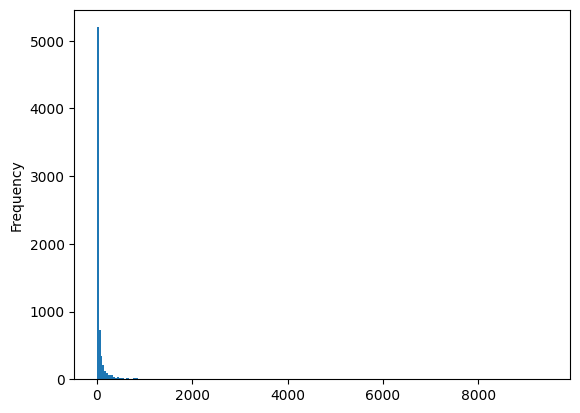

In [4]:
pd.Series(dict_tokens).plot.hist(bins = 250)
pd.Series(dict_tokens).describe()

In [5]:
g = nx.Graph()

for report, tokens_report in tokens_per_report.items():
    g.add_node(
        report,
        classification=report_class[report],
        part="report"
    )
    for token in tokens_report:
        if token in dict_tokens.keys():
            g.add_node(
                token,
                part="token"
            )
            g.add_edge(
                report,
                token
            )

print(g.order(), g.size(), nx.density(g))

12208 484674 0.006504684751599779


In [6]:
crop_to_largest_connected_component(g)

In [7]:
Sigma(
    g,
    node_color="classification"
)

Sigma(nx.Graph with 12,208 nodes and 484,674 edges)